__Group 20__:
- __Inês Rocha 20220052@novaims.unl.pt__
- __Pedro Ferreira 20220589@novaims.unl.pt__
- __Quintino Fernandes 20220634@novaims.unl.pt__

__Dataset__: https://drive.google.com/drive/folders/1NJOCRQ3ynA4BEOvWj5Ypr6iwi108LfOh?usp=share_link

(This is the non-zipped version, so one can see the images themselves. For the notebook, we use a zipped version, whose link is in the cell where the folder is imported. This is the dataset that we import to the model notebook, so it already has transformations that are made in preprocessing).

_References:_
1. [Complete guide to transfer learning & fine-tuning in Keras (2020)](https://keras.io/guides/transfer_learning/#train-the-top-layer)
2. [Keras Applications](https://keras.io/api/applications/)

__Summary of the notebook:__

In this notebook we:

- Using the Keras trainable API, we load a model(ResNet50V2) pre-trained on ImageNet, we build a top layer on top of it and lastly we use it to classify our dataset
- To do this we need to:
  - First augment and pre-process the data
  - Then we build a base model around the loaded model and train the top layer, meaning that we freeze the loaded layers from the imported model
  - Then finally we unfreeze the base model and train the entire model end-to-end with a low learning rate.

# 1. Import the dataset

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Sequential, layers, initializers, regularizers, optimizers, metrics 

import os
import shutil
import random 
import zipfile

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import ListedColormap

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import gdown

We upload the zip file with our Skin Cancer dataset.

In [ ]:
url = 'https://drive.google.com/uc?id=1tQsRxytmTgUW3zV5VjYoOw467-23mZ1H'
output = 'data.zip'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1tQsRxytmTgUW3zV5VjYoOw467-23mZ1H
To: /content/data.zip
100%|██████████| 698M/698M [00:04<00:00, 141MB/s]


'data.zip'

In this cell we extract the files from the data.zip file and loading into this workbook filesystem. 

In [ ]:
zip_ = zipfile.ZipFile('data.zip')
zip_.extractall()
zip_.close()
path = ""

After extracting all of the files, we define the paths for our train, test and validation folders.

In [ ]:
training_folder, val_folder, testing_folder = "/content/transformed_data/transformed_train/", \
"/content/transformed_data/transformed_val/", "/content/transformed_data/transformed_test/"

For the sake of ensuring that the data isn't continuously duplicated, we created this boolean flag for the function created bellow. 

In [ ]:
#Meter em True só na primeira vez
run = True

The **function make__copies()**, receives a folders and copies each photo n times and then stores it in the same folder. We will use this function as way to balance the dataset.

We used the fuction **make_n_copies()**,to populate the target folders in all folders except **nv**, because it had significantly more records than the others.

In [ ]:
def make_n_copies(folder, n_copies):

# Loop through each file in the images folder
  for image in os.listdir(folder):
    file_path = os.path.join(folder, image)
    # Create n_copies of the file
    for i in range(n_copies):
      new_filename = f"{image.split('.')[0]}_copy{i+1}.jpg"
      new_file_path = os.path.join(folder, new_filename)
      shutil.copy(file_path, new_file_path)

run = True
if run:
  make_n_copies(training_folder + 'akiec', 18)
  make_n_copies(training_folder + 'bcc', 11)
  make_n_copies(training_folder + 'bkl', 5)
  make_n_copies(training_folder + 'df', 51)
  make_n_copies(training_folder + 'mel', 5)
  make_n_copies(training_folder + 'vasc', 42)     

  run = False #to prevent the creation of copies multiple times

Here we define the main parameters to import the images from the directory to a tf dataset.

In [ ]:
image_size=(128,128)
crop_to_aspect_ratio=True
color_mode='rgb'
batch_size=64
label_mode="categorical"
validation_split=0.2
shuffle=True
seed=0

We defined the **image size** for our dataset to be **128x128 pixels**, because its a standard measure for images and so that images with diferent shapes dont conflict with our models. 

Our label mode is **categorical**, since our optimization problem is to predict which type of skin cancer is present in an image.

In this next cell, we generate our 3 tf datasets to train and test our model, with the parameters that we defined in the cell above.

In [ ]:
# Generate an object of type tf.data.Dataset 
ds_train = image_dataset_from_directory(training_folder, 
                                                image_size=image_size,
                                                crop_to_aspect_ratio=crop_to_aspect_ratio,
                                                color_mode=color_mode,
                                                batch_size=batch_size,
                                                label_mode=label_mode, 
                                                shuffle=shuffle,
                                                seed=seed)

ds_val = image_dataset_from_directory(val_folder, 
                                       image_size=image_size,
                                       crop_to_aspect_ratio=crop_to_aspect_ratio,
                                       color_mode=color_mode,
                                       batch_size=batch_size,
                                       label_mode=label_mode,                                     
                                       shuffle=shuffle,
                                       seed=seed)

ds_test = image_dataset_from_directory(testing_folder, 
                                       image_size=image_size,
                                       crop_to_aspect_ratio=crop_to_aspect_ratio,
                                       color_mode=color_mode,
                                       batch_size=batch_size,
                                       label_mode=label_mode,                                     
                                       shuffle=shuffle,
                                       seed=seed)

Found 30185 files belonging to 7 classes.
Found 1703 files belonging to 7 classes.
Found 1503 files belonging to 7 classes.


After the creation of the ds_train/test/val datasets we can confirm that the function read all the files for each folder.


# 2. Model Definition

First of all, we need to define some things prior to starting the models. Below we iterate in our training, particularly to get the input shape automatically.

In [ ]:
iter_train = iter(ds_train)
batch_x_train, batch_y_train = iter_train.next()

In [ ]:
input_shape = tuple(batch_x_train.shape)

The function below is based on the procedure of our deep learning classes. We input the model, learning rate and nr of epochs and it will give us a print of each epoch's measures. We added the precision and recall to the accuracy and AUC because we have an unbalanced set and even having oversampled the training set, we kept the other two sets unbalanced, because we thought it would simulate better real life. The function will also return the history callbacks of the model, so we can later use them to compare models. We also added the f1score to the history dataframe we are outputing, using the precision and recall, because it is a good measure of quality of a model with imbalanced data.

In [ ]:
#depois voltar a mudar o numero de epochs
def compilation(cnn, learning_rate = 0.001, epochs = 2):
  cnn.compile(loss="categorical_crossentropy",
              optimizer=optimizers.Adam(learning_rate=learning_rate),  
              metrics=[metrics.CategoricalAccuracy(name='accuracy'),
                       metrics.AUC(name='AUROC'),
                       metrics.Precision(name='precision'),
                       metrics.Recall(name='recall')])
  
  history = cnn.fit(ds_train, validation_data=ds_val, epochs=epochs, verbose=1)
  # 3. 
  df_hist = pd.DataFrame.from_dict(history.history)
  df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)

  #calculating the f1score for each epoch (train and validation)
  df_hist['f1'] = 2*(df_hist['precision']*df_hist['recall'])/(df_hist['precision'] + df_hist['recall'])
  df_hist['val_f1'] = 2*(df_hist['val_precision']*df_hist['val_recall'])/(df_hist['val_precision']+df_hist['val_recall'])
  
  return df_hist

The function below, also based on the classes, to plot the progress of the model through the epochs. Because of the imbalance, we decided it would be more important to plot the f1_score, while still keeping an eye on the accuracy, so the rest of the measures won't be seen in this plot, but will always be visible inside the model's history. The loss function will also always be present.


In [ ]:
def plot_hist(df_hist):
  secondary_y = ["f1", "val_f1", "accuracy", "val_accuracy"] 

  ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                    secondary_y = secondary_y, 
                    kind="line", figsize=(6, 3), grid=True, legend=True,
                    ylabel="Categorical cross-entropy", 
                    xlabel="Epoch", title="Learning curves", 
                    style=[".--", ".-"]*3,
                    color=['darkred', 'indianred', "darkblue", "royalblue", "seagreen", "darkseagreen"], 
                          alpha=0.75, fontsize=10)
  ax.right_ax.set_ylabel("F1 Score and Accuracy")
  ax.right_ax.legend(loc=(1.15, 0.65), framealpha=1.0)
  ax.right_ax.set_ylim(0.45, 1.05)
  ax.legend(loc=(1.15, 0.40), framealpha=1.0)
  plt.show()

# 3. Transfer learning

First of all we need to import the model we are going to use for the transfer learning.

- We import it pre-trained on the ImageNet dataset
- Include_top is false because we're going to build the top layer on our own model

In [ ]:
base_model = keras.applications.ResNet50V2(
    weights="imagenet",
    input_shape= (128,128,3),
    include_top=False
)

94668760/94668760 [==============================] - 1s 0us/step


Base_model.trainable is False, meaning that we are freezing the bottom layer, so we firstly train only the top layers that we add to our model

In [ ]:
base_model.trainable = False

## 3.1 Data Augmentation and Pre-process

In this section we pre-process and do the data augmentation that we did on our best model. To do this we create a layer to do both the augmentation and the pre-process on our model

In [ ]:
augmentation = Sequential([layers.RandomFlip(), 
                           layers.RandomRotation(factor=0.3), 
                           layers.RandomZoom(height_factor=0.1, width_factor=0.1),
                           layers.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1))
                          ])

In [ ]:
preprocess = Sequential([augmentation,layers.BatchNormalization()])

## 3.2 Base Model

Here we build our model:

- First we define the input-shape
- Then we add the data augmentation and pre-process layer
- We then add the imported model as a layer
- And lastly we build the top-layer of our model

In [ ]:
inputs = keras.Input(shape=(128, 128, 3))

x = preprocess(inputs)
x = base_model(x, training=False)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.GlobalMaxPooling2D()(x)

outputs = keras.layers.Dense(7,activation="softmax", 
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))(x)
modelT = keras.Model(inputs, outputs)

modelT.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 128, 128, 3)       12        
                                                                 
 resnet50v2 (Functional)     (None, 4, 4, 2048)        23564800  
                                                                 
 batch_normalization_2 (Batc  (None, 4, 4, 2048)       8192      
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 4, 4, 2048)        0         
                                                                 
 global_max_pooling2d_1 (Glo  (None, 2048)             0         
 balMaxPooling2D)                                          

## 3.3 Top layer Training

We use our trusted compilation function to train our newly built model, we use 15 epochs to match our best model that we created before

In [ ]:
frozen_transfer_model = compilation(modelT, epochs=15)

Epoch 1/15
472/472 [==============================] - 98s 193ms/step - loss: 2.7017 - accuracy: 0.3142 - AUROC: 0.6885 - precision: 0.3354 - recall: 0.2541 - val_loss: 2.1168 - val_accuracy: 0.4345 - val_AUROC: 0.7709 - val_precision: 0.4746 - val_recall: 0.3670
Epoch 2/15
472/472 [==============================] - 88s 184ms/step - loss: 1.9889 - accuracy: 0.4089 - AUROC: 0.7737 - precision: 0.4560 - recall: 0.3411 - val_loss: 1.9376 - val_accuracy: 0.4375 - val_AUROC: 0.7916 - val_precision: 0.4835 - val_recall: 0.3705
Epoch 3/15
472/472 [==============================] - 88s 184ms/step - loss: 1.7193 - accuracy: 0.4545 - AUROC: 0.8096 - precision: 0.5082 - recall: 0.3717 - val_loss: 1.3448 - val_accuracy: 0.5931 - val_AUROC: 0.8793 - val_precision: 0.6421 - val_recall: 0.5267
Epoch 4/15
472/472 [==============================] - 88s 184ms/step - loss: 1.5537 - accuracy: 0.4931 - AUROC: 0.8333 - precision: 0.5562 - recall: 0.4034 - val_loss: 1.6068 - val_accuracy: 0.5085 - val_AUROC: 

In [ ]:
frozen_transfer_model

,loss,accuracy,AUROC,precision,recall,val_loss,val_accuracy,val_AUROC,val_precision,val_recall,Epoch,f1,val_f1
0,2.701685,0.314196,0.688492,0.335374,0.254133,2.116754,0.434527,0.770861,0.474563,0.366999,1,0.289155,0.413907
1,1.988855,0.408912,0.773731,0.455955,0.341063,1.937602,0.437463,0.791639,0.483525,0.370523,2,0.390228,0.419548
2,1.719255,0.454464,0.809571,0.508152,0.371708,1.344827,0.593071,0.879337,0.642090,0.526718,3,0.429350,0.578710
3,1.553733,0.493126,0.833285,0.556205,0.403412,1.606802,0.508514,0.835407,0.555388,0.432766,4,0.467645,0.486469
4,1.443099,0.517476,0.849064,0.587676,0.426238,1.404231,0.548444,0.862588,0.610646,0.471521,5,0.494105,0.532140
5,1.365104,0.536160,0.859964,0.615112,0.442041,1.137228,0.643570,0.903990,0.705796,0.564885,6,0.514409,0.627528
6,1.304476,0.547424,0.869120,0.627601,0.450621,1.306842,0.556665,0.876490,0.615616,0.481503,7,0.524586,0.540362
7,1.263436,0.556700,0.875418,0.637434,0.458970,1.337792,0.553729,0.869966,0.622888,0.476218,8,0.533677,0.539767
8,1.225084,0.567434,0.880910,0.656157,0.465364,1.528129,0.498532,0.841917,0.560524,0.426894,9,0.544531,0.484667
9,1.188289,0.577273,0.886610,0.665311,0.471592,1.293776,0.566060,0.873876,0.646409,0.480916,10,0.551947,0.551515


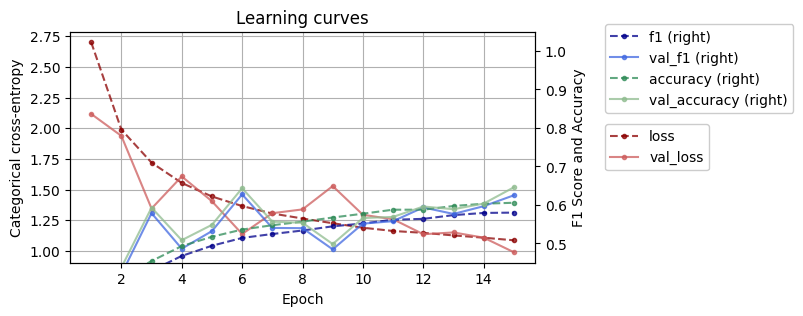

In [ ]:
plot_hist(frozen_transfer_model)

We can observe the model is underfiting, but here we only trained the top layer so we don't need to read to much into these results

## 3.3 Fine-Tuning

In this section we are going to train the whole model, unfreezing the layers from the imported model

In [ ]:
base_model.trainable = True
modelT.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 128, 128, 3)       12        
                                                                 
 resnet50v2 (Functional)     (None, 4, 4, 2048)        23564800  
                                                                 
 batch_normalization_2 (Batc  (None, 4, 4, 2048)       8192      
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 4, 4, 2048)        0         
                                                                 
 global_max_pooling2d_1 (Glo  (None, 2048)             0         
 balMaxPooling2D)                                          

As we can see above we have all the 23.5 million params able to train

Below we use our compilation function again and run it for 15 epochs to match once again our best built model. We use a very low learning_rate because it's what's recommend for fine tuning
 the model so we don't run the risk of overfitting
 

In [ ]:
transfer_model = compilation(modelT, epochs=15, learning_rate=0.00001)

Epoch 1/15
472/472 [==============================] - 171s 229ms/step - loss: 1.0364 - accuracy: 0.6255 - AUROC: 0.9107 - precision: 0.7202 - recall: 0.5161 - val_loss: 1.0547 - val_accuracy: 0.6148 - val_AUROC: 0.9107 - val_precision: 0.6928 - val_recall: 0.5232
Epoch 2/15
472/472 [==============================] - 107s 224ms/step - loss: 1.0069 - accuracy: 0.6309 - AUROC: 0.9154 - precision: 0.7262 - recall: 0.5186 - val_loss: 1.0760 - val_accuracy: 0.6025 - val_AUROC: 0.9073 - val_precision: 0.6850 - val_recall: 0.5132
Epoch 3/15
472/472 [==============================] - 108s 226ms/step - loss: 0.9861 - accuracy: 0.6418 - AUROC: 0.9187 - precision: 0.7342 - recall: 0.5278 - val_loss: 1.0438 - val_accuracy: 0.6060 - val_AUROC: 0.9125 - val_precision: 0.6895 - val_recall: 0.5255
Epoch 4/15
472/472 [==============================] - 107s 224ms/step - loss: 0.9745 - accuracy: 0.6457 - AUROC: 0.9207 - precision: 0.7363 - recall: 0.5378 - val_loss: 1.0508 - val_accuracy: 0.6183 - val_AUR

In [ ]:
transfer_model

,loss,accuracy,AUROC,precision,recall,val_loss,val_accuracy,val_AUROC,val_precision,val_recall,Epoch,f1,val_f1
0,1.036372,0.625542,0.910708,0.720157,0.516051,1.054717,0.614797,0.910746,0.692846,0.523194,1,0.601254,0.596186
1,1.006851,0.630909,0.915428,0.726223,0.518569,1.075971,0.602466,0.907339,0.684953,0.513212,2,0.605075,0.586774
2,0.986140,0.641776,0.918662,0.734215,0.527779,1.043807,0.605989,0.912540,0.689522,0.525543,3,0.614113,0.596468
3,0.974457,0.645685,0.920653,0.736324,0.537784,1.050772,0.618321,0.911278,0.692248,0.524369,4,0.621585,0.596726
4,0.960647,0.647606,0.922809,0.746025,0.544078,1.026912,0.621257,0.915146,0.702079,0.535526,5,0.629246,0.607595
5,0.944620,0.654166,0.925318,0.747483,0.550936,1.034954,0.613623,0.913988,0.703588,0.529654,6,0.634333,0.604355
6,0.934879,0.659400,0.926643,0.749131,0.556667,1.029485,0.616559,0.915416,0.692890,0.537874,7,0.638715,0.605620
7,0.926293,0.659930,0.928065,0.749643,0.555806,1.020135,0.625954,0.916456,0.696510,0.539049,8,0.638333,0.607746
8,0.909432,0.669372,0.930510,0.759387,0.566805,1.022614,0.624780,0.916574,0.699620,0.540223,9,0.649113,0.609675
9,0.906107,0.665397,0.930976,0.757632,0.565645,1.008513,0.629477,0.918170,0.711316,0.542572,10,0.647712,0.615590


## 3.4 Model Comparision

Now we are going to compare our transfer learning model with our best model

In [ ]:
test_scores_final = modelT.evaluate(ds_test,verbose = 0)

print(f'Test Accuracy: {test_scores_final[1]}')

print(f'Test f1_score: {2*test_scores_final[-2]*test_scores_final[-1]/(test_scores_final[-2]+test_scores_final[-1])}')

Test Accuracy: 0.6407185792922974
Test f1_score: 0.6283582205699967


Above we have the test scores from our Transfer Learning model, below we have the scores from our best model.

- As we can see the Transfer Learning Model is not near as good as our best model, falling way below the scores we expected

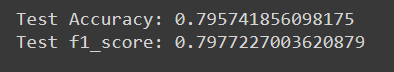

Below we can see: 

- First the plot from the Transfer Learning model
- Secondly the plot from our best model

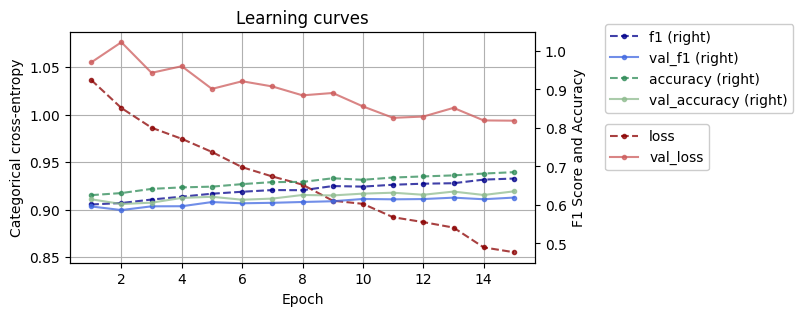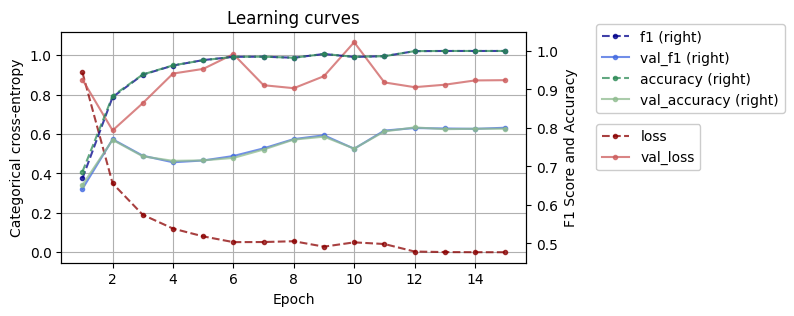

Our Transfer Learning model did not reach the performance of our best model built, we can also observe on the plot from the former that the loss values were still decreasing so the Transfer Model could get a bit higher on performance with more epochs, but we think it wouldn't reach the performance of our homemade model.